In [93]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)
sys.path.append('src')
from train_test import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Uploading the original dataset (uncomment if you need)

In [2]:
# ! sudo apt install curl
# ! curl -O  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz

In [3]:
# ! tar -xf ./lastfm-dataset-360K.tar.gz

### Reading the dataset

In [4]:
lastfm_360_demo = pd.read_csv('lastfm-dataset-360K/usersha1-profile.tsv', sep='\t', header=None,
                             names=['user_email', 'gender', 'age', 'country', 'signup'])
lastfm_360_behav = pd.read_csv('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, 
                              names=['user_email', 'artist_id', 'artist_name', 'plays'])

Transform "signup" column into datetime type

In [5]:
lastfm_360_demo["signup"] = pd.to_datetime(lastfm_360_demo.signup)

Make users' IDs as numbers

In [6]:
uniq_users = lastfm_360_demo['user_email'].unique()
upd_users_ids = dict((id_, i) for i, id_ in enumerate(uniq_users))
lastfm_360_demo['user_email'] = lastfm_360_demo['user_email'].map(lambda x: upd_users_ids[x])

### Exploring and cleaning demographic data

In [7]:
lastfm_360_demo.head()

,user_email,gender,age,country,signup
0,0,f,22.0,Germany,2007-02-01
1,1,f,NaN,Canada,2007-12-04
2,2,NaN,NaN,Germany,2006-09-01
3,3,m,19.0,Mexico,2008-04-28
4,4,m,28.0,United States,2006-01-27


In [8]:
lastfm_360_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_email  359347 non-null  int64         
 1   gender      326572 non-null  object        
 2   age         284447 non-null  float64       
 3   country     359347 non-null  object        
 4   signup      359347 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 13.7+ MB


In [9]:
lastfm_360_demo.describe(include='all', datetime_is_numeric=True)

,user_email,gender,age,country,signup
count,359347.000000,326572,284447.000000,359347,359347
unique,NaN,2,NaN,239,NaN
top,NaN,m,NaN,United States,NaN
freq,NaN,241642,NaN,67044,NaN
mean,179673.000000,NaN,25.098046,NaN,2007-08-01 08:05:37.732609280
min,0.000000,NaN,-1337.000000,NaN,2002-10-29 00:00:00
25%,89836.500000,NaN,20.000000,NaN,2006-10-21 00:00:00
50%,179673.000000,NaN,23.000000,NaN,2007-09-29 00:00:00
75%,269509.500000,NaN,28.000000,NaN,2008-07-17 00:00:00
max,359346.000000,NaN,1002.000000,NaN,2009-11-11 00:00:00


Then, we should process demographic data. First, we put unrealistic ages as NaNs.

In [10]:
ages = lastfm_360_demo['age'].unique()
lastfm_360_demo['age'].replace(ages[ages > 99], np.nan, inplace=True)
lastfm_360_demo['age'].replace(ages[ages < 8], np.nan, inplace=True)

Make one-hot encoding for gender, country, and age with sure that NaNs have some pattern

In [11]:
lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['gender']))
lastfm_360_demo = lastfm_360_demo.drop('gender', axis=1)

lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['country']))
lastfm_360_demo = lastfm_360_demo.drop('country', axis=1)

lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['age']))
lastfm_360_demo = lastfm_360_demo.drop('age', axis=1)

Extract features from sign-up date

In [12]:
lastfm_360_demo['year'] = lastfm_360_demo['signup'].dt.year
lastfm_360_demo['month'] = lastfm_360_demo['signup'].dt.month
lastfm_360_demo['weekday'] = lastfm_360_demo['signup'].dt.weekday
lastfm_360_demo['day'] = lastfm_360_demo['signup'].dt.day
lastfm_360_demo = lastfm_360_demo.drop(columns='signup') 
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['year'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['month'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['day'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['weekday'])], axis=1)
lastfm_360_demo = lastfm_360_demo.drop(columns=['year', 'month', 'weekday', 'day']) 

### Exploring and cleaning behavioral data

In [13]:
lastfm_360_behav.head()

,user_email,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [14]:
lastfm_360_behav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17535655 entries, 0 to 17535654
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_email   object
 1   artist_id    object
 2   artist_name  object
 3   plays        int64 
dtypes: int64(1), object(3)
memory usage: 535.1+ MB


In [15]:
lastfm_360_behav.describe(include='all', datetime_is_numeric=True)

,user_email,artist_id,artist_name,plays
count,17535655,17309518,17535451,1.753566e+07
unique,358868,160112,292363,NaN
top,13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5,a74b1b7f-71a5-4011-9441-d0b5e4122711,radiohead,NaN
freq,166,77254,77254,NaN
mean,NaN,NaN,NaN,2.151932e+02
std,NaN,NaN,NaN,6.144815e+02
min,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,3.500000e+01
50%,NaN,NaN,NaN,9.400000e+01
75%,NaN,NaN,NaN,2.240000e+02


In [16]:
lastfm_360_behav.isna().sum(0)

user_email          0
artist_id      226137
artist_name       204
plays               0
dtype: int64

We drop samples with missed artist's name because there are no many of them and it is only one artist in 202 cases and an artist that doesn't have the name and the ID in 2 cases.

In [17]:
lastfm_360_behav = lastfm_360_behav.drop(lastfm_360_behav.loc[lastfm_360_behav['artist_name'].isnull()].index)

Then, we have strange user emails "dec 27, 2008" and "sep 20, 2008" in the behavioral data which are not found in the demographic one. It is only 86 samples and it can be some test data, thus we drop it. (It is not needed for ALS for example)

In [18]:
lastfm_360_behav = lastfm_360_behav.drop(lastfm_360_behav.loc[lastfm_360_behav['user_email'].str.contains(' ')].index) 

Since the part of samples where ID is missed makes up about 1% of data and don't include important systematic patterns like feats or the most popular artists, we drop it for simplicity. (another approach would be to say that the ID is equal names but this might make data incorrect because names are not unique at all)

In [19]:
lastfm_360_behav = lastfm_360_behav.drop(lastfm_360_behav.loc[lastfm_360_behav['artist_id'].isnull()].index)

There are cases where one ID corresponds several artists names. We fix it by assigning one name to all entries of a given ID

In [20]:
uniq_artist_names = lastfm_360_behav.groupby('artist_id')['artist_name'].unique()
lastfm_360_behav['artist_name'] = lastfm_360_behav.apply(lambda x: uniq_artist_names[x['artist_id']][0], axis=1)

Make artists' and users' IDs as numbers

In [21]:
uniq_artist_ids = lastfm_360_behav['artist_id'].unique()
upd_ids = dict((id_, i) for i, id_ in enumerate(uniq_artist_ids))
lastfm_360_behav['artist_id'] = lastfm_360_behav['artist_id'].map(lambda x: upd_ids[x])
lastfm_360_behav['user_email'] = lastfm_360_behav['user_email'].map(lambda x: upd_users_ids[x])

In [22]:
print(lastfm_360_behav.artist_id.unique().shape)
print(lastfm_360_behav.user_email.unique().shape)
print(lastfm_360_demo.user_email.unique().shape)

(160111,)
(358856,)
(359347,)


We can see that there are more users that don't have records in the behavioral part of the dataset. Let us drop them because it is about 500 users, i.e. ~0.1%.

In [23]:
no_plays_users = list(set(lastfm_360_demo.user_email.unique()).symmetric_difference(
    set(lastfm_360_behav.user_email.unique())))
lastfm_360_demo = lastfm_360_demo[~lastfm_360_demo.user_email.isin(no_plays_users)]

In [24]:
print(lastfm_360_behav.user_email.unique().shape)
print(lastfm_360_demo.user_email.unique().shape)

(358856,)
(358856,)


### Handling number of plays

[Text(-250.0, 0, 'qntal'),
 Text(0.0, 0, 'the beatles'),
 Text(250.0, 0, 'nick drake'),
 Text(500.0, 0, 'kate nash'),
 Text(750.0, 0, 'amy macdonald'),
 Text(1000.0, 0, 'the lawrence arms'),
 Text(1250.0, 0, '(hed) p.e'),
 Text(1500.0, 0, 'meat loaf'),
 Text(1750.0, 0, 'qntal'),
 Text(2000.0, 0, ''),
 Text(2250.0, 0, '')]

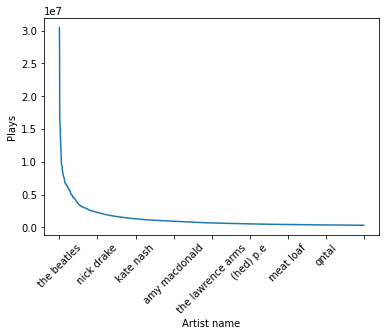

In [25]:
artist_plays = lastfm_360_behav.groupby('artist_name')['plays'].sum().sort_values(ascending=False)
# sns.distplot(artist_plays[:100])
g = artist_plays[:2000].plot()
g.set_ylabel('Plays')
g.set_xlabel('Artist name')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
# plt.savefig('plays_vs_artists.png')

We can see that the distribution of the plays is highly concentrated around a few hundreds of plays. Thus, we reduce it to more useful range by taking log (notice that samples with 0 plays were already dropped simultaneously with NaNs). Further, in the training phase, we will standardize them using the maximum number of plays calculated from the train sample.

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='plays', ylabel='Density'>

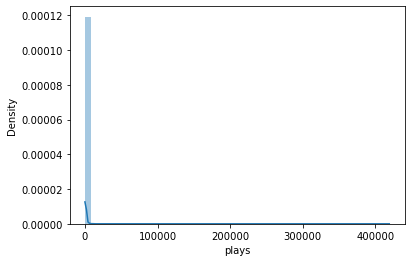

In [26]:
sns.distplot(lastfm_360_behav['plays'])
# plt.savefig('plays_density.png')

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_plays', ylabel='Density'>

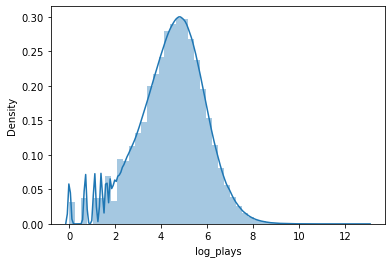

In [27]:
lastfm_360_behav['log_plays'] = np.log(lastfm_360_behav['plays'])
sns.distplot(lastfm_360_behav['log_plays'])

### Splitting behavioral data into train, validation and test

In [28]:
ratings = lastfm_360_behav[['user_email', 'artist_id', 'log_plays']]
train, test = train_test_split(ratings, test_frac=0.1)
train = train.sample(frac=1).reset_index(drop=True) 
train, valid = train_test_split(train, test_frac=0.1)

In [29]:
print(train.shape, test.shape, ratings.shape)

(14049677, 3) (1742895, 3) (17309231, 3)


### Saving clean dataset

In [30]:
# lastfm_360_behav.to_csv('lastfm-dataset-360K/behav-360k-processed.csv', index=False)
lastfm_360_demo.to_csv('lastfm-dataset-360K/demo-360k-processed.csv', index=False)
train.to_csv('lastfm-dataset-360K/train.csv', index=False)
valid.to_csv('lastfm-dataset-360K/valid.csv', index=False)
test.to_csv('lastfm-dataset-360K/test.csv', index=False)

### Selecting users to test artists recommendations

In [56]:
diversity = lastfm_360_behav.groupby('user_email')['user_email'].count()

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


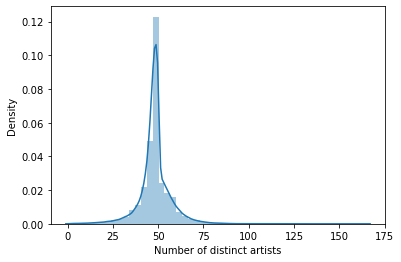

In [85]:
g = sns.distplot(diversity)
g.set_xlabel('Number of distinct artists')
plt.savefig('diversity.png')

In [92]:
np.save('lastfm-dataset-360K/test_users', diversity[diversity >= 50].sample(1000).index)